# Productivity Across the Entire 15-day Period



In [1]:
library(tidyverse)
library(broom)

# library(brms) # install.packages("brms")
# library(loo) # install.packages("loo")
# library(rstanarm) # install.packages("rstanarm")

library(lubridate)
library(bayesplot)

library(lme4)
library(yardstick) # install.packages("yardstick")

library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


This is bayesplot version 1.7.2

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


For binary classification, the first factor level is assumed to be the event.
Use the 

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

# Helper functions

In [3]:
## Function that takes in a model, the validation set, the name of the predicted column,
## and returns a plot of the ROC curve
plot_ROC <- function(mod, val_data, col_name) {
    val_data$estimate = predict(mod, val_data, type = "response")
    roc_curve(val_data, {{ col_name }}, estimate, event_level = 'second') %>%
        ggplot(aes(x = 1 - specificity, y = sensitivity)) +
        geom_path() +
        geom_abline(lty = 3) +
        coord_equal() +
        theme_bw()
}

In [4]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = user_dataset_column_types) %>%
    mutate(
        Group = factor(hp_enabled, levels = c(0, 1), labels = c("C", "HP")),
        platform = factor(reg_on_mobile == 1, c(FALSE, TRUE), c("desktop", "mobile")),
        ## Registration month, for later joins on month
        reg_month = floor_date(user_registration_timestamp, unit = 'month'),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_2w = num_article_edits_2w + num_other_edits_2w,
        num_total_edits = num_total_edits_24hrs + num_total_edits_2w,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_2w,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_2w,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_2w = num_article_reverts_2w + num_other_reverts_2w,
        num_total_reverts = num_reverts_24hrs + num_reverts_2w,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_2w > 0),
        is_retained_other = is_activated_other & (num_other_edits_2w > 0),
        is_retained = is_activated & ((num_article_edits_2w + num_other_edits_2w) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_2w - num_article_reverts_2w) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_2w - num_other_reverts_2w) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_2w + num_other_edits_2w -
              num_article_reverts_2w - num_other_reverts_2w) > 0)
    ) 
}

In [5]:
## Function that takes in the filename of the active editors dataset,
## and adds a registration month column for easy joining with the user dataset.
read_active_editors_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = active_editors_column_types) %>%
    mutate(wiki_db = factor(wiki_db),
           reg_month = month + months(1))
}

# Experiment Configuration Variables

We define a set of configuration variables that are useful for the analysis. One obvious one is where the edit dataset is located.

A less obvious one is a variable for when the experiment started. We often use this seeking to model the community's initial response to changes in newcomer behaviour, as well as long-term trends in the outcome variable when working with user data gathered across a relatively long time period.

In [6]:
## Path to the datasets with user edits
user_dataset_filenames <- c(
    '/home/nettrom/src/2021-Growth-structured-tasks/datasets/add-a-link-edit-data.tsv'
    )

## Column types in the dataset: wiki is a factor, HP variant is a factor, registration is a date time,
## everything else are integers.
user_dataset_column_types <- 'fiTiifiiiiiiii'

## Path to the dataset with counts of the number of active editors
active_editors_filenames <- c()

## Column types in the active editors dataset: month is a date, wiki is a factor
active_editors_column_types <- 'Dfiii'

## Deployment timestamps for Add a Link on each of the wikis
## Note that we turn wiki_db into a factor, otherwise wiki_db in the edit dataset
## becomes a character after joining the two.
exp_start_timestamps <- tribble(
    ~wiki_db, ~exp_start_timestamp,
    'arwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'bnwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'cswiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'viwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'fawiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'frwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'huwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'plwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'rowiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'ruwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),

) %>% mutate(wiki_db = factor(wiki_db))

## Path to the dataset with editing status at account registration
editing_status_filenames <- c()

## Column types in the editing status dataset: wiki is a factor, everything else are integers
editing_status_column_types <- 'fii'

## Path to the dataset with Welcome Survey responses
survey_response_filenames <- c()

## Columns types in the survey response data: user ID is an integer, number of languages is a number,
## everything else are factors
survey_response_column_types <- 'fifffn'

# Data import and setup

In [7]:
user_edit_data <- map_dfr(user_dataset_filenames, read_user_dataset)

In [8]:
nrow(user_edit_data)

[1] 130179

## Time since experiment start

Join the edits data with the experiment timestamps and measure time since the start to enable controlling for that:

In [9]:
user_edit_data <- user_edit_data %>%
    inner_join(exp_start_timestamps, by = 'wiki_db') %>%
    mutate(
        # Time as a measurement since deployment
        exp_days = difftime(user_registration_timestamp, exp_start_timestamp, units = 'days'),
        ln_exp_days = ifelse(exp_days < 0, 0, log(1 + as.numeric(exp_days))),
        ln_exp_weeks = ifelse(exp_days < 0, 0, log(1 + as.numeric(exp_days)/7))
    )

In [10]:
nrow(user_edit_data)

[1] 130179

Made sure that we're not dropping any users at this stage, we're good to move forward.

## Additional variables

We've previously focused on Control vs Growth Features in our analysis. In this case we'll focus primarily on Unstructured Link Task vs Add a Link, but also check against the control group. This means we want the single variable `Group` to reflect one of three options depending on `hp_enabled` and `hp_variant`

In [20]:
user_edit_data <- user_edit_data %>%
    mutate(Group = factor(ifelse(
        hp_enabled == 0, 'Control',
        ifelse(hp_variant == 'control', 'Unstructured', 'Add-a-link')),
                          c('Control', 'Unstructured', 'Add-a-link')))

Our productivity model will fit on the total number of constructive article edits, so we need a variable for that.

In [19]:
user_edit_data <- user_edit_data %>%
    mutate(num_total_const_article_edits = num_article_edits_24hrs - num_article_reverts_24hrs +
           num_article_edits_2w - num_article_reverts_2w)

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [12]:
user_edit_data %>%
    group_by(wiki_db, Group) %>%
    summarize(n = n())

`summarise()` regrouping output by 'wiki_db' (override with `.groups` argument)



wiki_db,Group,n
<fct>,<fct>,<int>
arwiki,Control,7698
arwiki,Unstructured,13426
arwiki,Add-a-link,13213
bnwiki,Control,1583
bnwiki,Unstructured,2664
bnwiki,Add-a-link,2679
cswiki,Control,787
cswiki,Unstructured,1419
cswiki,Add-a-link,1447


## Splitting into Training, Test, and Validation Datasets

Split the dataset into training, test, and validation data sets.

In [13]:
## set the random seed so train/test/validation splits can be reproduced
set.seed(42)

trainIndex <- caret::createDataPartition(user_edit_data$Group,
                                         p = .8,
                                         list = FALSE,
                                         times = 1)
user_data_train = user_edit_data[trainIndex,]
user_data_second = user_edit_data[-trainIndex,]

testIndex = caret::createDataPartition(user_data_second$Group, p = .5, list = FALSE, times = 1)

user_data_test = user_data_second[testIndex,]
user_data_validate = user_data_second[-testIndex,]

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [14]:
user_data_test$is_activated_fct <- factor(user_data_test$is_activated,
                                          labels = c('No', 'Yes'))
user_data_validate$is_activated_fct <- factor(user_data_validate$is_activated,
                                          labels = c('No', 'Yes'))

## Visualizing Productivity

We'll make box plots of editing based on group, and we'll focus on constructive article edits because that's where we see the strongest effects. This plot uses the `log10(1 + x)` transformation so we get to see all users who didn't make any edits.

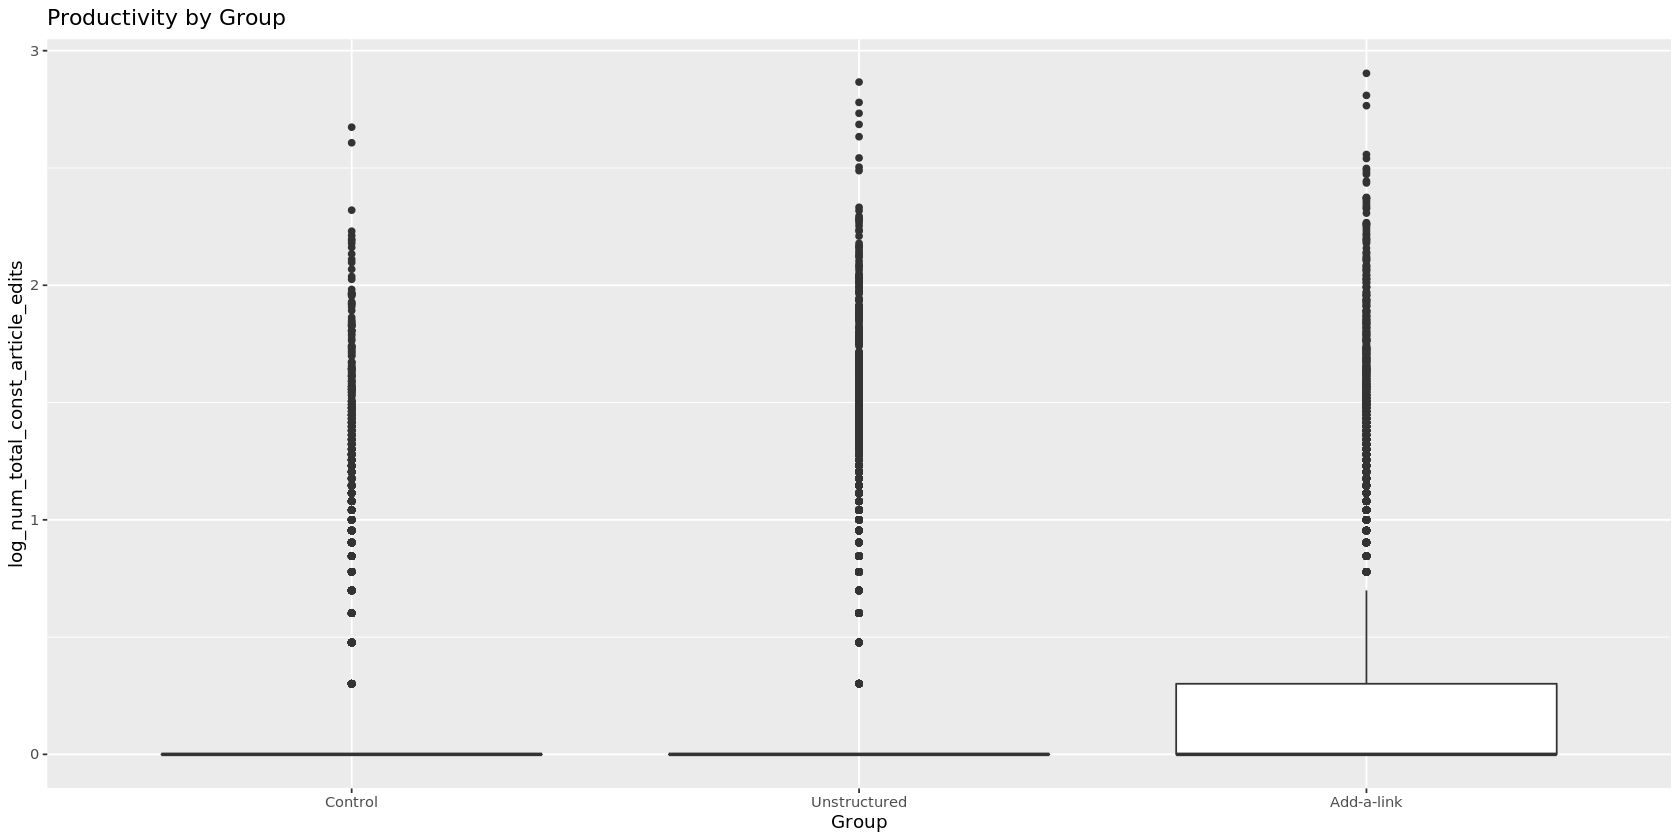

In [16]:
user_edit_data %>%
    mutate(log_num_total_const_article_edits = log10(1 + num_article_edits_24hrs - num_article_reverts_24hrs +
           num_article_edits_2w - num_article_reverts_2w)) %>%
    ggplot(aes(x = Group, y = log_num_total_const_article_edits)) +
        labs(title = 'Productivity by Group', yaxis_title = 'Number of constructive edits (log 10 scale)') +
        geom_boxplot()

It looks like there are some interesting differences between the groups when it comes to the distribution of the number of edits. Let's summarize per group.

In [21]:
user_edit_data %>%
    mutate(num_total_const_article_edits = num_article_edits_24hrs - num_article_reverts_24hrs +
           num_article_edits_2w - num_article_reverts_2w) %>%
    group_by(platform, Group) %>%
    summarise(min_edits = min(num_total_const_article_edits),
              perc_5_edits = quantile(num_total_const_article_edits, probs = c(0.05)),
              perc_10_edits = quantile(num_total_const_article_edits, probs = c(0.1)),
              perc_25_edits = quantile(num_total_const_article_edits, probs = c(0.25)),
              median_edits = median(num_total_const_article_edits),
              mean_edits = mean(num_total_const_article_edits),
              perc_75_edits = quantile(num_total_const_article_edits, probs = c(0.75)),
              perc_90_edits = quantile(num_total_const_article_edits, probs = c(0.9)),
              perc_95_edits = quantile(num_total_const_article_edits, probs = c(0.95)),
              max_edits = max(num_total_const_article_edits),
             .groups = 'keep'
             )

platform,Group,min_edits,perc_5_edits,perc_10_edits,perc_25_edits,median_edits,mean_edits,perc_75_edits,perc_90_edits,perc_95_edits,max_edits
<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
desktop,Control,0,0,0,0,0,1.225,1,2,5,471
desktop,Unstructured,0,0,0,0,0,1.295,1,2,5,734
desktop,Add-a-link,0,0,0,0,0,1.565,1,3,5,644
mobile,Control,0,0,0,0,0,0.732,0,1,3,404
mobile,Unstructured,0,0,0,0,0,0.816,0,1,3,601
mobile,Add-a-link,0,0,0,0,0,1.013,0,2,4,800


## Priors

In [ ]:
## Note that using a student_t distribution for the prior is beneficial because that
## distribution handles outliers better than a Normal.
## See https://jrnold.github.io/bayesian_notes/robust-regression.html
## Thanks to Mikhail for sending that to me!
priors <- prior(cauchy(0, 2), class = sd) +
  prior(student_t(5, 0, 10), class = b)

# Constructive Article Productivity with Group-level Variation

In the analysis of activation, we found meaningful group-level variation in `platform`, and indications of an interaction between `platform` and `Group`. When analysing retention, we found that it mainly followed activation. This analysis is slightly different in that we'll count all edits across the entire time period (in other words, users can activate after the first 24 hours and it'll matter). We'll start with a model that's similar to the activation model, and then fit one or two competing models for later checking with `loo`.

In [ ]:
## FIXME: fit this model again because the original one didn't have `platform`
## as a population-level predictor for zero-inflation
constr.article.edits.all.days.zinb.1 <- brm(
  bf(num_total_const_article_edits ~ platform * Group +
     (1 + platform | wiki_db),
     zi ~ platform + (1 + platform | wiki_db)),
    data = user_edit_data,
    family = zero_inflated_negbinomial(),
    prior = priors,
    iter = 800,
    control = list(adapt_delta = 0.99,
                 max_treedepth = 15)
)

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(constr.article.edits.all.days.zinb.1,
     file='../models/constr.article.edits.all.days.zinb.1.Robj')

In [23]:
summary(constr.article.edits.all.days.zinb.1)

 Family: zero_inflated_negbinomial 
  Links: mu = log; shape = identity; zi = logit 
Formula: num_total_const_article_edits ~ platform * Group + (1 + platform | wiki_db) 
         zi ~ platform + (1 + platform | wiki_db)
   Data: user_edit_data (Number of observations: 130179) 
  Draws: 4 chains, each with iter = 800; warmup = 400; thin = 1;
         total post-warmup draws = 1600

Group-Level Effects: 
~wiki_db (Number of levels: 10) 
                                    Estimate Est.Error l-95% CI u-95% CI Rhat
sd(Intercept)                           0.30      0.09     0.17     0.50 1.00
sd(platformmobile)                      0.41      0.13     0.23     0.73 1.00
sd(zi_Intercept)                        4.47      1.51     2.36     7.76 1.00
sd(zi_platformmobile)                   2.68      1.05     1.31     5.24 1.00
cor(Intercept,platformmobile)          -0.12      0.33    -0.71     0.53 1.00
cor(zi_Intercept,zi_platformmobile)    -0.66      0.31    -0.99     0.12 1.00
              

In [39]:
user_edit_data %>%
    group_by(Group) %>%
    summarize(geomean = exp(mean(log(1 + num_total_const_article_edits))) -1,
              propzero = sum(ifelse(num_total_const_article_edits == 0, 1, 0))/n())

`summarise()` ungrouping output (override with `.groups` argument)



Group,geomean,propzero
<fct>,<dbl>,<dbl>
Control,0.319,0.771
Unstructured,0.333,0.759
Add-a-link,0.378,0.738


In [45]:
user_edit_data %>%
    filter(num_total_const_article_edits > 0) %>%
    group_by(Group) %>%
    summarize(mean = mean(num_total_const_article_edits),
              median = median(num_total_const_article_edits),
              geomean = exp(mean(log(num_total_const_article_edits))))

`summarise()` ungrouping output (override with `.groups` argument)



Group,mean,median,geomean
<fct>,<dbl>,<dbl>,<dbl>
Control,4.24,2,2.09
Unstructured,4.37,2,2.05
Add-a-link,4.90,2,2.12


Warning message:
“Argument 'nsamples' is deprecated. Please use argument 'ndraws' instead.”


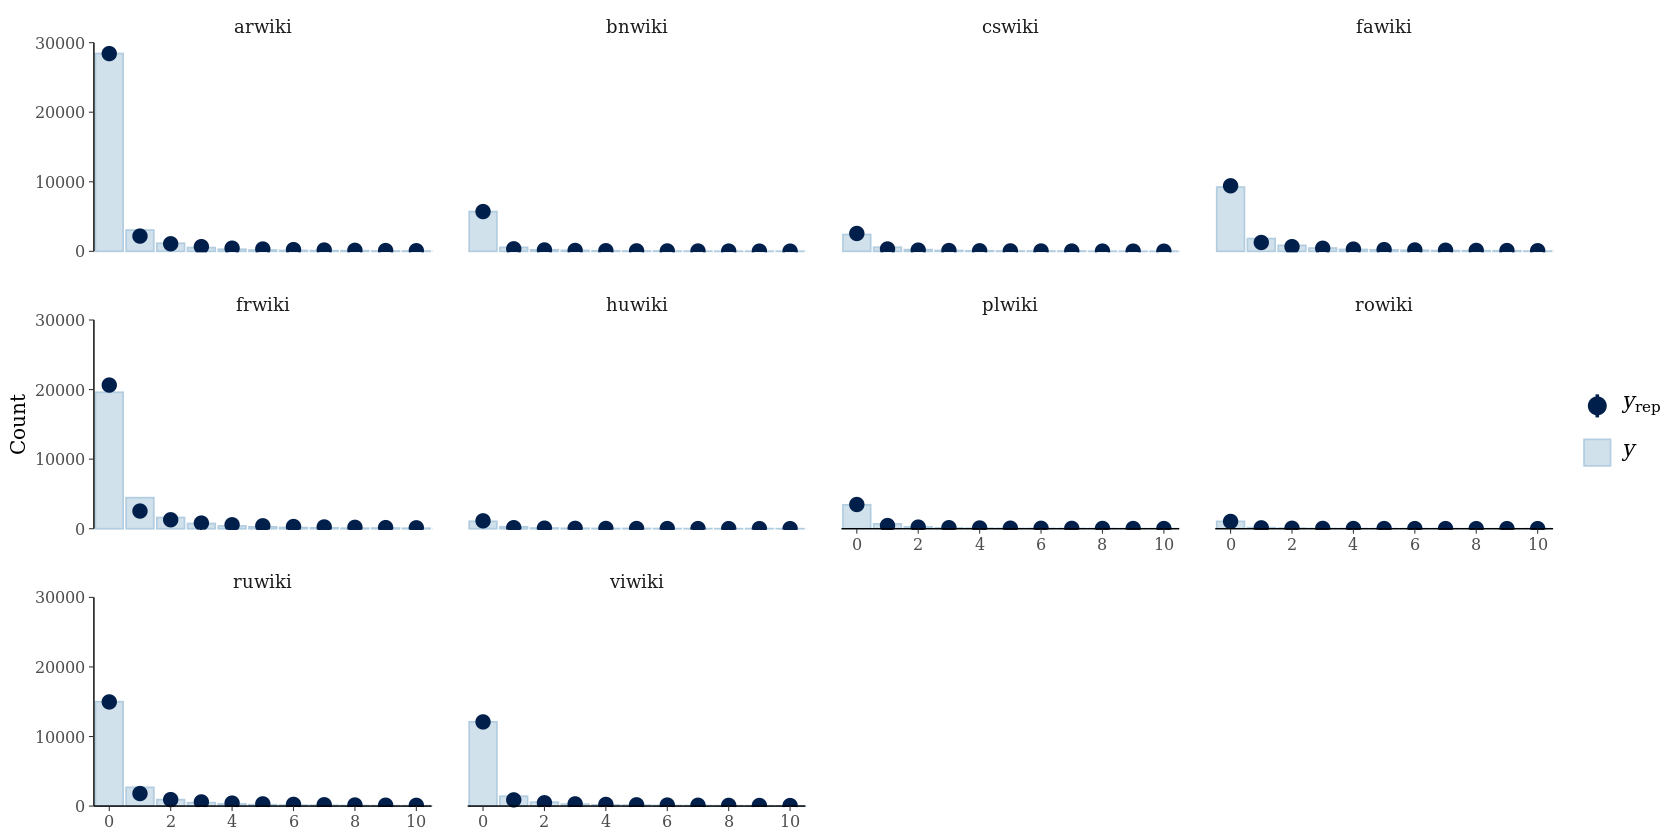

In [46]:
pp_check(constr.article.edits.all.days.zinb.1,
         ndraws = 100, type = "bars_grouped", group = "wiki_db") +
  ggplot2::coord_cartesian(xlim = c(0, 10));

Zooming in on the non-zero part of the distributions, because the high zero-rate results in such a compressed graph.

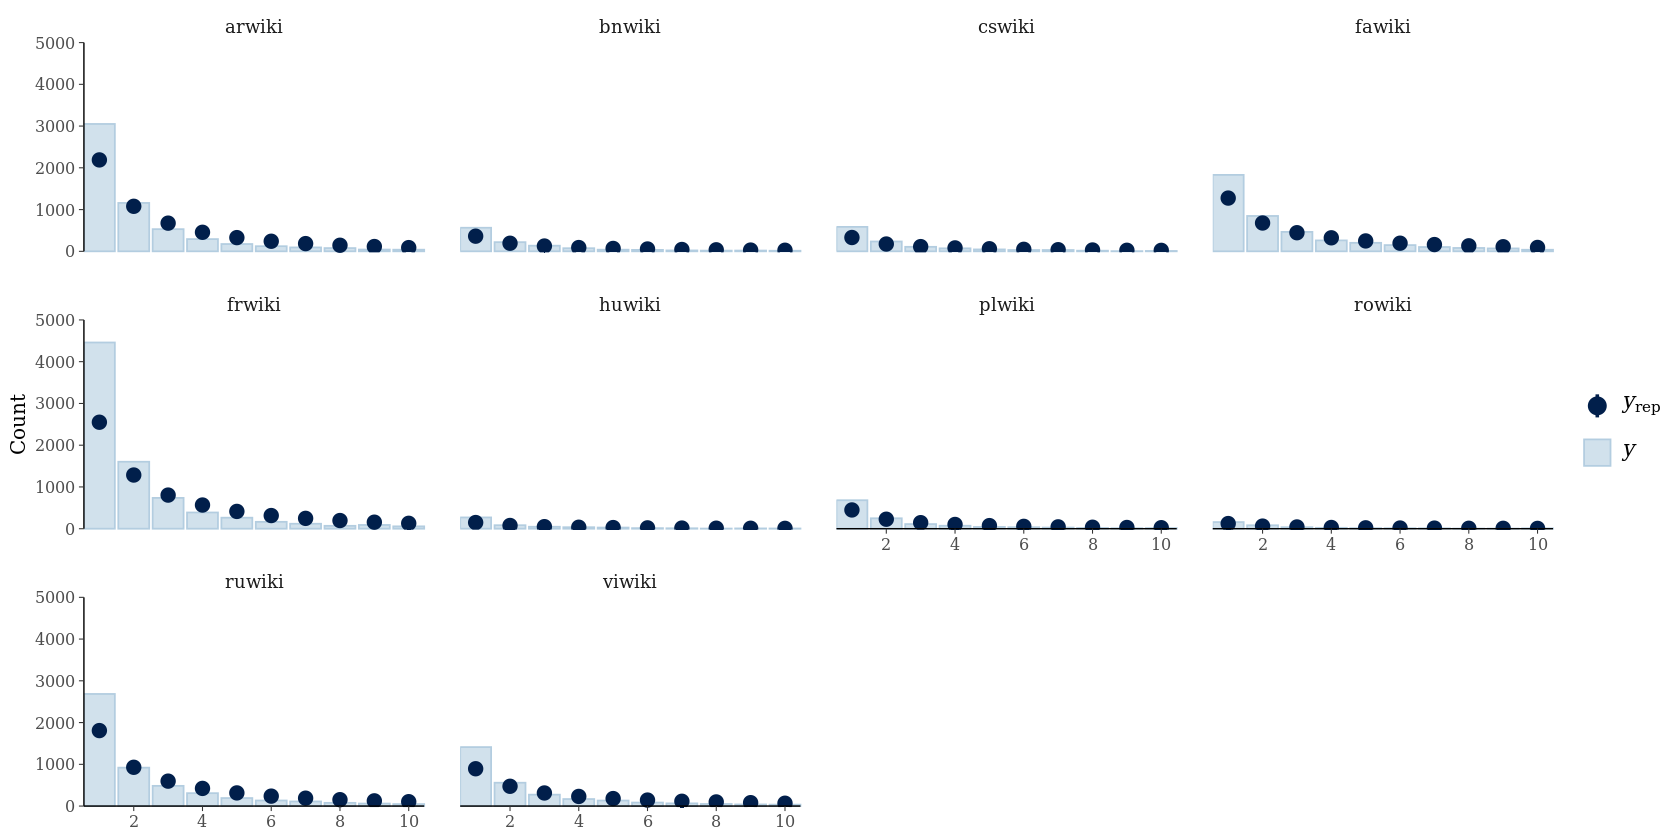

In [49]:
pp_check(constr.article.edits.all.days.zinb.1,
         ndraws = 100, type = "bars_grouped", group = "wiki_db") +
  ggplot2::coord_cartesian(xlim = c(1, 10), ylim = c(0, 5000));

Getting the incident rate for Add a Link, with the 95% credible interval:

In [51]:
fixef(constr.article.edits.all.days.zinb.1)

,Estimate,Est.Error,Q2.5,Q97.5
Intercept,0.3842,0.1020,0.1813,0.5859
zi_Intercept,-4.5906,1.4909,-7.8975,-1.7015
platformmobile,-0.3743,0.1463,-0.6824,-0.0826
GroupUnstructured,0.0460,0.0302,-0.0146,0.1037
GroupAddMaMlink,0.2402,0.0302,0.1825,0.3005
platformmobile:GroupUnstructured,0.0225,0.0452,-0.0676,0.1134
platformmobile:GroupAddMaMlink,0.0166,0.0458,-0.0731,0.1061
zi_platformmobile,2.7126,1.1877,0.6943,5.3659


In [54]:
exp(fixef(constr.article.edits.all.days.zinb.1)[5,"Estimate"])

[1] 1.27

In [55]:
exp(fixef(constr.article.edits.all.days.zinb.1)[5,"Q2.5"])

[1] 1.2

In [56]:
exp(fixef(constr.article.edits.all.days.zinb.1)[5,"Q97.5"])

[1] 1.35

Let's use the geometric mean to calculate the increase this time:

In [21]:
control.geomean <- exp(
    mean(
        log(
            1 + user_edit_data[user_edit_data$Group == "Control",]$num_total_const_article_edits
        )
    )
) - 1
round(control.geomean, 3)

[1] 0.319

In [22]:
unstructured.geomean <- exp(
    mean(
        log(
            1 + user_edit_data[user_edit_data$Group == "Unstructured",]$num_total_const_article_edits
        )
    )
) - 1
round(unstructured.geomean, 3)

[1] 0.333

In [23]:
addalink.geomean <- exp(
    mean(
        log(
            1 + user_edit_data[user_edit_data$Group == "Add-a-link",]$num_total_const_article_edits
        )
    )
) - 1
round(addalink.geomean, 3)

[1] 0.378

In [21]:
round(unstructured.geomean - control.geomean, 3)

[1] 0.014

In [22]:
round(addalink.geomean - control.geomean, 3)

[1] 0.059

In [23]:
round(100 * (unstructured.geomean - control.geomean) / control.geomean, 1)

[1] 4.5

In [24]:
round(100 * (addalink.geomean - control.geomean) / control.geomean, 1)

[1] 18.7

Difference between the unstructured and structured task groups:

In [24]:
round(addalink.geomean - unstructured.geomean, 3)

[1] 0.045

In [25]:
round(100 * (addalink.geomean - unstructured.geomean) / unstructured.geomean, 1)

[1] 13.5

Geometric means if we exclude all users who made 0 edits:

In [45]:
control.geomean.nonzero <- exp(
    mean(
        log(
            user_edit_data[(user_edit_data$Group == "Control") &
                           (user_edit_data$num_total_const_article_edits > 0),]$num_total_const_article_edits
        )
    )
)
round(control.geomean.nonzero, 3)

[1] 2.09

In [37]:
unstructured.geomean.nonzero <- exp(
    mean(
        log(
            user_edit_data[(user_edit_data$Group == "Unstructured") &
                               (user_edit_data$num_total_const_article_edits > 0),]$num_total_const_article_edits
        )
    )
)
round(unstructured.geomean.nonzero, 3)

[1] 2.05

In [38]:
addalink.geomean.nonzero <- exp(
    mean(
        log(
            user_edit_data[(user_edit_data$Group == "Add-a-link") &
                           (user_edit_data$num_total_const_article_edits > 0),]$num_total_const_article_edits
        )
    )
)
round(addalink.geomean.nonzero, 3)

[1] 2.12

In [39]:
round(unstructured.geomean.nonzero - control.geomean.nonzero, 3)

[1] -0.039

In [40]:
round(addalink.geomean.nonzero - control.geomean.nonzero, 3)

[1] 0.029

In [41]:
round(100 * (unstructured.geomean.nonzero - control.geomean.nonzero) / control.geomean.nonzero, 1)

[1] -1.9

In [42]:
round(100 * (addalink.geomean.nonzero - control.geomean.nonzero) / control.geomean.nonzero, 1)

[1] 1.4

In [84]:
user_edit_data %>%
    group_by(platform, Group) %>%
    summarise(geo_mean = exp(mean(log(1 + num_total_const_article_edits))) -1)

`summarise()` regrouping output by 'platform' (override with `.groups` argument)



platform,Group,geo_mean
<fct>,<fct>,<dbl>
desktop,Control,0.402
desktop,Unstructured,0.417
desktop,Add-a-link,0.462
mobile,Control,0.245
mobile,Unstructured,0.256
mobile,Add-a-link,0.301


# Graphs

## Edit Volume

`summarise()` ungrouping output (override with `.groups` argument)



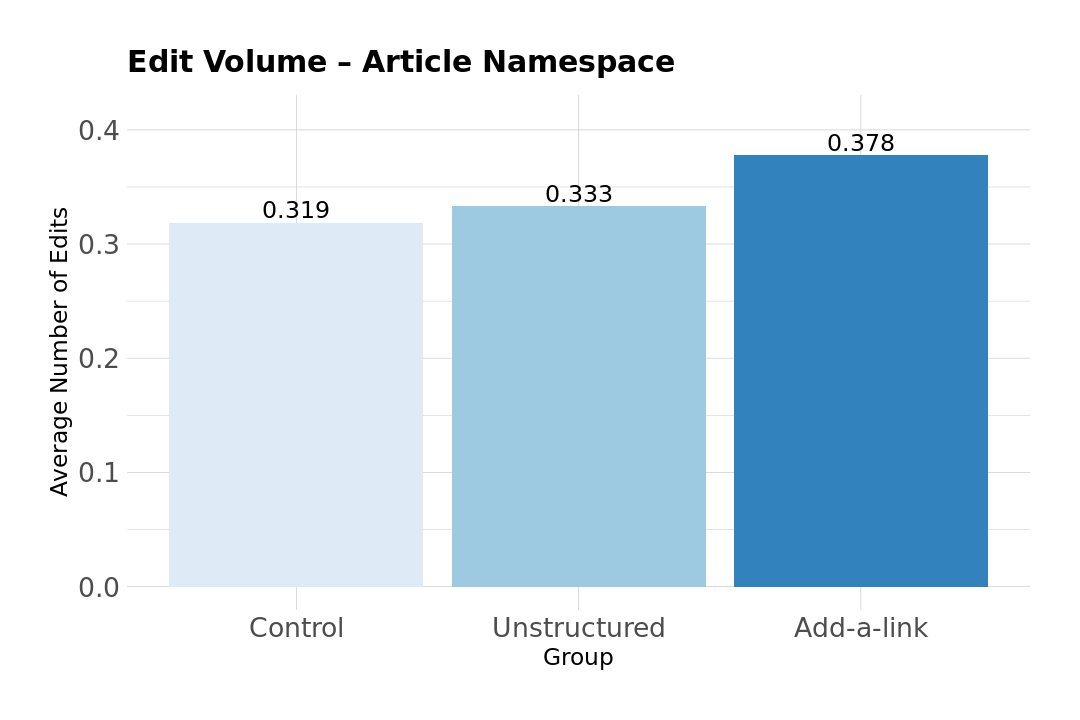

In [69]:
# Give me wider plots, please
options(repr.plot.width = 9, repr.plot.height = 6)

## Note to self: mutate() operates on a per-row basis, summarise() operates on the groups when using group_by()
user_edit_data %>%
    group_by(Group) %>%
    summarise(geo_mean = exp(mean(log(1 + num_total_const_article_edits))) -1) %>%
    ggplot(aes(x = Group, y = geo_mean, fill = Group)) +
        labs(title = 'Edit Volume – Article Namespace', x = 'Group', y = 'Average Number of Edits') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        geom_col() +
        scale_y_continuous(limits = c(0, 0.41)) +
        geom_text(aes(label = round(geo_mean, 3)), fontface = 'plain', nudge_y = 0.011, size = 5)
ggsave(
    'add-a-link-article-namespace-constructive-edit-volume-2021-experiment.png',
    path = 'graphs',
    width = 9, height = 6, units = "in", dpi = "screen")